In [1]:
### IMPORT PACKAGES ###

import pandas as pd
import numpy as np

# to make pretty plots
import plotly
import plotly.express as px
import plotly.graph_objects as go

# to play with time :-)
import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

In [2]:
print(globals().keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'pd', 'np', 'plotly', 'px', 'go', 'datetime', 'time', 'plt', 'sns', 'RandomForestClassifier', 'accuracy_score', 'confusion_matrix', 'classification_report', '_i2'])


In [3]:
### IMPORT THE DATA ###

if (('df' not in globals()) or ('df_test' not in globals() or ('df_validation' not in globals()))):
    ### IMPORT THE DATA ###
    df = pd.read_csv('final data/BPI_Challenge_2012-training.csv')
    df_test = pd.read_csv('final data/BPI_Challenge_2012-test.csv')
    df_validation = pd.read_csv('final data/BPI_Challenge_2012-validation.csv')
    case_column = "case concept:name"
    event_column = "event concept:name"
    timestamp_column = "event time:timestamp"
    timeformat_timestamp = "%Y-%m-%d %H:%M:%S.%f"
    lifecycle_column = 'event lifecycle:transition'
    amount_column = 'case AMOUNT_REQ'
    row_nr_column = 'row_nr'
    pred_event_otf = "OTF Prediction for Next Activity"
    df.loc[:,timestamp_column] = pd.to_datetime(df.loc[:,timestamp_column])#, format=timeformat_timestamp)
    df_validation.loc[:,timestamp_column] = pd.to_datetime(df_validation.loc[:,timestamp_column])#, format=timeformat_timestamp)
    df_test.loc[:,timestamp_column] = pd.to_datetime(df_test.loc[:,timestamp_column])#, format=timeformat_timestamp)


if ('amount_column_in_data' not in globals()):
    amount_column_in_data = True

In [4]:
#make a list with all possible events
all_events=list(df[event_column].unique())

In [5]:
# get most common event
df_most_common_event =pd.DataFrame(df[event_column].value_counts())
df_most_common_event.reset_index(inplace=True)
most_common_event = df_most_common_event.iloc[0,0]

In [6]:
df = df.sort_values(by=timestamp_column).reset_index(drop=True)
df_validation = df_validation.sort_values(by=timestamp_column).reset_index(drop=True)
df_test = df_test.sort_values(by=timestamp_column).reset_index(drop=True)
df

,Unnamed: 0,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,check
0,0,0,173688,2011-10-01T00:38:44.546+02:00,20000,A_SUBMITTED,COMPLETE,2011-10-01 00:38:44.546,train
1,1,1,173688,2011-10-01T00:38:44.546+02:00,20000,A_PARTLYSUBMITTED,COMPLETE,2011-10-01 00:38:44.880,train
2,2,2,173688,2011-10-01T00:38:44.546+02:00,20000,A_PREACCEPTED,COMPLETE,2011-10-01 00:39:37.906,train
3,3,3,173688,2011-10-01T00:38:44.546+02:00,20000,W_Completeren aanvraag,SCHEDULE,2011-10-01 00:39:38.875,train
4,4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,A_SUBMITTED,COMPLETE,2011-10-01 08:08:58.256,train
...,...,...,...,...,...,...,...,...,...
136618,136619,32302449033234,197135,2012-01-02T13:41:08.814+01:00,5000,A_DECLINED,COMPLETE,2012-01-12 11:42:00.140,train
136619,136618,32302449033233,197135,2012-01-02T13:41:08.814+01:00,5000,O_DECLINED,COMPLETE,2012-01-12 11:42:00.140,train
136620,136620,32302449033235,197135,2012-01-02T13:41:08.814+01:00,5000,W_Valideren aanvraag,COMPLETE,2012-01-12 11:42:03.525,train
136621,136621,35850092019724,199672,2012-01-10T19:08:54.759+01:00,18000,A_DECLINED,COMPLETE,2012-01-12 11:43:08.386,train


In [7]:
# additional columns that you want to include
additionalInfo = []

if amount_column_in_data == True:
    if amount_column not in list(df):
        amount_column = 'case RequestedAmount'
    additionalInfo.append(amount_column)


# make a list of the columns you need
columns = [case_column, event_column, lifecycle_column, timestamp_column]
columns.extend(additionalInfo)


# you can get rid of all the other columns, to make things faster

place =1
dataset = df[columns]
dataset_val = df_validation[columns]
dataset_test = df_test[columns]
dataset[row_nr_column] = dataset.index
dataset_val[row_nr_column] = dataset_val.index
dataset_test[row_nr_column] = dataset_test.index

if amount_column_in_data!=True:
    dataset[amount_column] = [0 for i in range(len(dataset))]
    dataset_val[amount_column] = [0 for i in range(len(dataset_val))]
    dataset_test[amount_column] = [0 for i in range(len(dataset_test))]


# round the amount column on 10000
if amount_column in list(dataset):
    dataset[amount_column] = [round(int(x),-4) for x in dataset[amount_column]]
    dataset_val[amount_column] = [round(int(x),-4) for x in dataset_val[amount_column]]
    dataset_test[amount_column] = [round(int(x),-4) for x in dataset_test[amount_column]]


print(dataset.head())

   case concept:name      event concept:name event lifecycle:transition  \
0             173688             A_SUBMITTED                   COMPLETE   
1             173688       A_PARTLYSUBMITTED                   COMPLETE   
2             173688           A_PREACCEPTED                   COMPLETE   
3             173688  W_Completeren aanvraag                   SCHEDULE   
4             173691             A_SUBMITTED                   COMPLETE   

     event time:timestamp  case AMOUNT_REQ  row_nr  
0 2011-10-01 00:38:44.546            20000       0  
1 2011-10-01 00:38:44.880            20000       1  
2 2011-10-01 00:39:37.906            20000       2  
3 2011-10-01 00:39:38.875            20000       3  
4 2011-10-01 08:08:58.256                0       4  


C:\Users\20203666\AppData\Local\Temp/ipykernel_12424/1261009798.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[row_nr_column] = dataset.index
C:\Users\20203666\AppData\Local\Temp/ipykernel_12424/1261009798.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_val[row_nr_column] = dataset_val.index
C:\Users\20203666\AppData\Local\Temp/ipykernel_12424/1261009798.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [8]:
### STORAGE ###
# we want to keep track of things that happen within one case

# caseStorage stores: key=instance, values= [event, previousEvent, event_id, previousEvent_id, lifecycle, previousLifecycle, amount, predictedEvent]
# to look up the previous event in this instance, and it's predicted TimePassed
caseStorage = {}

# we also want to keep track of the predictionError
# errorStorage stores: key=unique integer, values= [previousEvent, previousLifecycle, predictionError,predictedEvent, event]
errorStorage = {}

# we also want to add a log feature => we don't have to save this seperatly, just needed to check if having it makes sense.
# how many events of the same activty are running at the same time might be interesting
# concurentEvents = {}

def getFeatures(case, event):
    """
    This function extracts extra info of incomming event from the caseStorage
    """

    # if the case is already in storage, info of previous event is extracted from caseStorage
    if case in caseStorage:

        previousEvent = caseStorage[case][0]
        previousLifecycle = caseStorage[case][4]
        predictedEvent = caseStorage[case][7]
        previousEvent_id = caseStorage[case][2]
        previousRow_nr = caseStorage[case][8]

        # if prediction of previous event is correct, change predictionError to 1 and add the event to errorstorage
        if predictedEvent == event:
            predictionError = 1
        else:
            predictionError = 0
        errorStorage[previousRow_nr] = [previousEvent, previousLifecycle, predictionError,predictedEvent, event]

    # if it is a new case set info of previous event to None
    else:
        previousEvent = None
        previousEvent_id = None
        previousLifecycle = None

    #if event in eventList:
        # you want to find how many times this activity occurs without any additional information
        #howManyConcurentEvents = [x[0] for x in caseStorage.values()].count(event)
    #else:
        #howManyConcurentEvents = ''

    howManyConcurentEvents = [x[0] for x in caseStorage.values()].count(event)
    #howManyConcurentEvents = [x[0].split('_XX_')[0] for x in instanceStorage.values()].count(event)
    if howManyConcurentEvents > 3:
        # when an event is the last event in an instance, it won't get out of the instance storage
        # so this number can get really high for events that are common to be the last one
        # even though they are not actually running at the same time. Therefore I will top it off at 3.
        howManyConcurentEvents = 3
    #howManyConcurentEvents= ''

    return previousEvent, previousEvent_id, previousLifecycle, howManyConcurentEvents



In [9]:
### THE MODEL ###
# We start with only one feature: the historical average time between two events based on the previous event
# You don't need a second model for the test set, since you train your model on the training-set and then use it on the test-set

predictionModel = {}

def getPrediction(event_id):
    """
    gets the prediction of a certain event_id
    """

    try:
        # get the event of an event_id with the highest occurrence
        return sorted(predictionModel[event_id],key=predictionModel[event_id].get)[-place]

    except:
        # if event_id not in predictionModel return the most frequent event in train data as prediction
        return most_common_event



def updatePredictionModel(this_event_id, event):
    """
    updates PredictionModel with the true event of a event_id
    """
    # makes dict with all events as key and 0 as value
    all_events_dict=dict([(event,0) for event in all_events])

    if this_event_id != None:

        # if event_id already in predictionModel update it by +1 to the true event
        try:
            predictionModel[this_event_id][event] +=1
        # if event_id not in predictionModel, add it to the dict with the all_events_dict as key and update it by +1 tot the true event
        except:
            predictionModel[this_event_id] = all_events_dict
            predictionModel[this_event_id][event] +=1



In [10]:
### RUNNING THE MODEL ###
# We have to run the model line by line, we can't do things in parallel, otherwise it's not on the fly

def processEvent(case, event, lifecycle, row_nr, amount=None):
    """
    the input is the the raw info of a case
    the function updates the predictionModel, caseStorage and the errorStorage
    """
    #gets info of the incomming event
    previousEvent, previousEvent_id, previousLifecycle, howManyConcurentEvents = getFeatures(case, event)

    # makes the event_id based on the features and is used to make the prediction
    event_id = str(event)+'_XX_'+str(amount)+'_XX_'+str(previousEvent)+'_XX_'+str(previousLifecycle)+'_XX_'+str(howManyConcurentEvents)

    # gets the prediction of event_id from the predictionModel
    predictedEvent = getPrediction(event_id)

    # update storage
    caseStorage[case] = [event, previousEvent, event_id, previousEvent_id, lifecycle, previousLifecycle, amount, predictedEvent, row_nr]

    # update predictionModel
    updatePredictionModel(previousEvent_id, event)


### Run over all lines =>

# Start the stopwatch / counter
start_time = time.process_time()

# running the on-the-fly model for each row

[processEvent(case, event, lifecycle, row_nr, amount) for case, event, lifecycle, row_nr, amount in zip(dataset[case_column],dataset[event_column], dataset[lifecycle_column], dataset[row_nr_column], dataset[amount_column])]

# Stop the stopwatch / counter
end_time = time.process_time()

print("dict: Elapsed time during the whole program in seconds:", end_time-start_time)


dict: Elapsed time during the whole program in seconds: 34.375


In [11]:
# count keeps track on how many the model was correct and divides by the amount of predictions made
count_train=0
predictions_index_train = []
for key in errorStorage:
    count_train += errorStorage[key][2]
    predictions_index_train.append([key,errorStorage[key][3]])
len_set_train = len(errorStorage)
train_acc_event_otf = count_train/len_set_train
print(f'train accuracy:{train_acc_event_otf}')
for case in caseStorage:
    predictions_index_train.append([caseStorage[case][8], caseStorage[case][7]])
print(f'length df = {len(df)}, length predictions = {len(predictions_index_train)}')
train_pred_event_otf = [x[1] for x in sorted(predictions_index_train)]

train accuracy:0.807655621127405
length df = 136623, length predictions = 136623


In [12]:
places = [1, 2]
places_dict = {}
for place in places:
    errorStorage = {}
    caseStorage = {}
    [processEvent(case, event, lifecycle, row_nr, amount) for case, event, lifecycle, row_nr, amount in zip(dataset_val[case_column],dataset_val[event_column], dataset_val[lifecycle_column], dataset_val[row_nr_column], dataset_val[amount_column])]

    # count keeps track on how many the model was correct and divides by the amount of predictions made

    count_val=0
    predictions_index_val = []
    for key in errorStorage:
        count_val += errorStorage[key][2]
        predictions_index_val.append([key, errorStorage[key][3]])
    len_set_val = len(errorStorage)
    val_acc_event_otf = count_val/len_set_val
    print(f'test accuracy:{val_acc_event_otf}')
    places_dict[place] = val_acc_event_otf
place = max(places_dict, key=places_dict.get)


test accuracy:0.7715315954365431
test accuracy:0.13637169710941657


In [13]:
# empty errorStorage and run model on test set
errorStorage = {}
caseStorage = {}
[processEvent(case, event, lifecycle, row_nr, amount) for case, event, lifecycle, row_nr, amount in zip(dataset_test[case_column],dataset_test[event_column], dataset_test[lifecycle_column], dataset_test[row_nr_column], dataset_test[amount_column])]

# count keeps track on how many the model was correct and divides by the amount of predictions made

count_test=0
predictions_index_test = []
y_pred = []
y_true = []
for key in errorStorage:
    y_pred.append(errorStorage[key][3])
    y_true.append(errorStorage[key][4])
    count_test += errorStorage[key][2]
    predictions_index_test.append([key, errorStorage[key][3]])

len_set_test = len(errorStorage)
test_acc_event_otf = count_test/len_set_test
print(f'test accuracy:{test_acc_event_otf}')

for case in caseStorage:
    predictions_index_test.append([caseStorage[case][8], caseStorage[case][7]])
print(f'length df = {len(df_test)}, length predictions = {len(predictions_index_test)}')
test_pred_event_otf = [x[1] for x in sorted(predictions_index_test)]

test accuracy:0.8171079218693332
length df = 40892, length predictions = 40892


In [14]:
amount_column = 'case:AMOUNT_REQ'
df[pred_event_otf] = train_pred_event_otf
df_test[pred_event_otf] = test_pred_event_otf

In [15]:
df = df.sort_values(by=[case_column, timestamp_column]).reset_index(drop=True)
df_test = df_test.sort_values(by=[case_column, timestamp_column]).reset_index(drop=True)

training_event_accuracy = len(df[(df[pred_event_otf].shift(periods=1)==df[event_column]) & (df[case_column].shift(periods=1) == df[case_column])]) * 100 / len(df[df[case_column].shift(periods=1) == df[case_column]])

test_event_accuracy = len(df_test[(df_test[pred_event_otf].shift(periods=1)==df_test[event_column]) & (df_test[case_column].shift(periods=1) == df_test[case_column])]) * 100 / len(df_test[df_test[case_column].shift(periods=1) == df_test[case_column]])

training_event_accuracy, test_event_accuracy

(80.7655621127405, 81.71079218693332)

C:\Users\20203666\AppData\Local\Temp/ipykernel_12424/2889728480.py:2: RuntimeWarning: divide by zero encountered in log
  matrix = np.log(confusion_matrix(y_true, y_pred, labels=axis_labels))


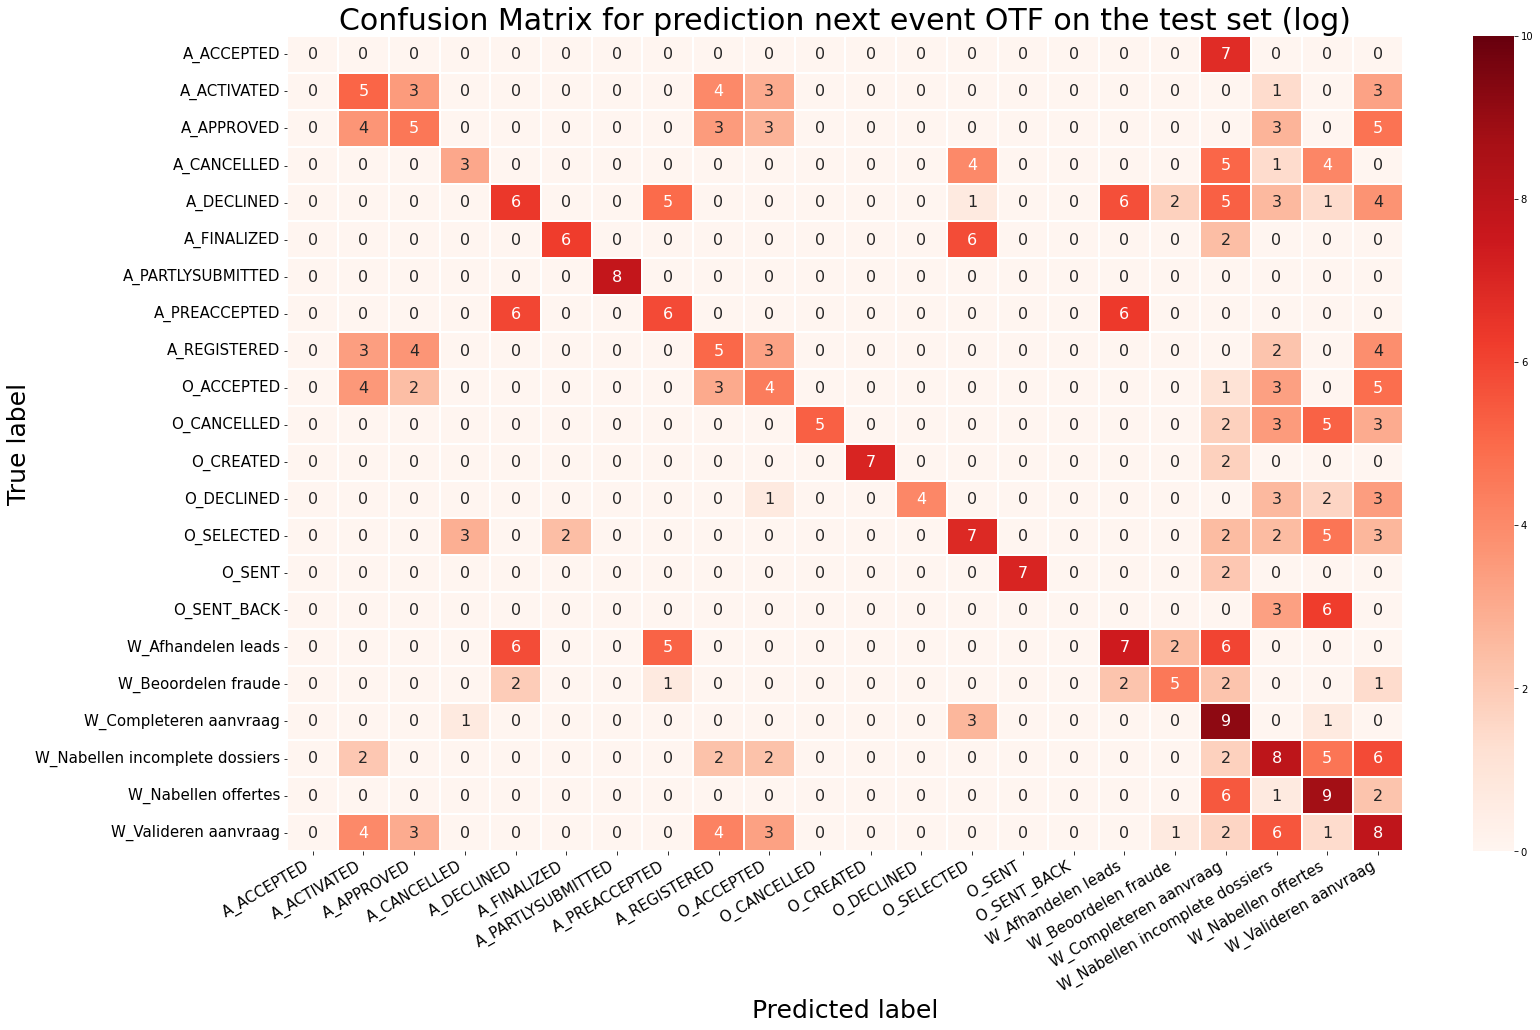

In [18]:
axis_labels = sorted(list(set(y_true)))
matrix = np.log(confusion_matrix(y_true, y_pred, labels=axis_labels))
df_matrix = pd.DataFrame(matrix, index=axis_labels, columns=axis_labels)
for x in df_matrix:
    df_matrix.loc[df_matrix[x]==-np.inf,x] = 0
#get the number of predictions per group
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]

#get the percentage of predictions per group
#group_percentages = ["{0:.0%}".format(value) for value in matrix.flatten()/np.sum(matrix)]

#create labels for each cell of the heatmap
labels = [f"{v1}" for v1 in group_counts]

#reshape into size of the matrix
labels = np.asarray(labels).reshape(matrix.shape)

#set fig size depending on the size of the matrix
plt.figure(figsize=(25,15))

#plot the matrix
sns.heatmap(df_matrix, fmt='', annot=labels, annot_kws={'size':16}, linewidths = 0.3
            , linecolor = 'white', cbar = True, cmap='Reds', vmin=0, vmax=10)

#set event labels and change color scheme of the matrix
#, xticklabels=events, yticklabels=events, cmap="YlGnBu"

#set x and y label orinetation and size
plt.xticks(rotation=30, horizontalalignment='right', fontsize = 15)
plt.yticks(rotation=0, horizontalalignment='right', fontsize = 15)

#add labels to the plot
plt.xlabel('Predicted label', fontsize=25 )
plt.ylabel('True label', fontsize=25)
plt.title('Confusion Matrix for prediction next event OTF on the test set (log)', fontsize=30)

#plt.savefig('confusion_matrix.png')

plt.show()

model with: event, previousevent, previouslifecycle, howmanyconcurentevents, amount
Accuracy test: 0.813

model with: event, previousevent, previouslifecycle, howmanyconcurentevents
Accuracy test: 0.816

model with: event, previousevent, previouslifecycle, amount
Accuracy test: 0.816

model with: event, previousevent, previouslifecycle
Accuracy test: 0.817

model with: event, previousevent
Accuracy test: 0.804

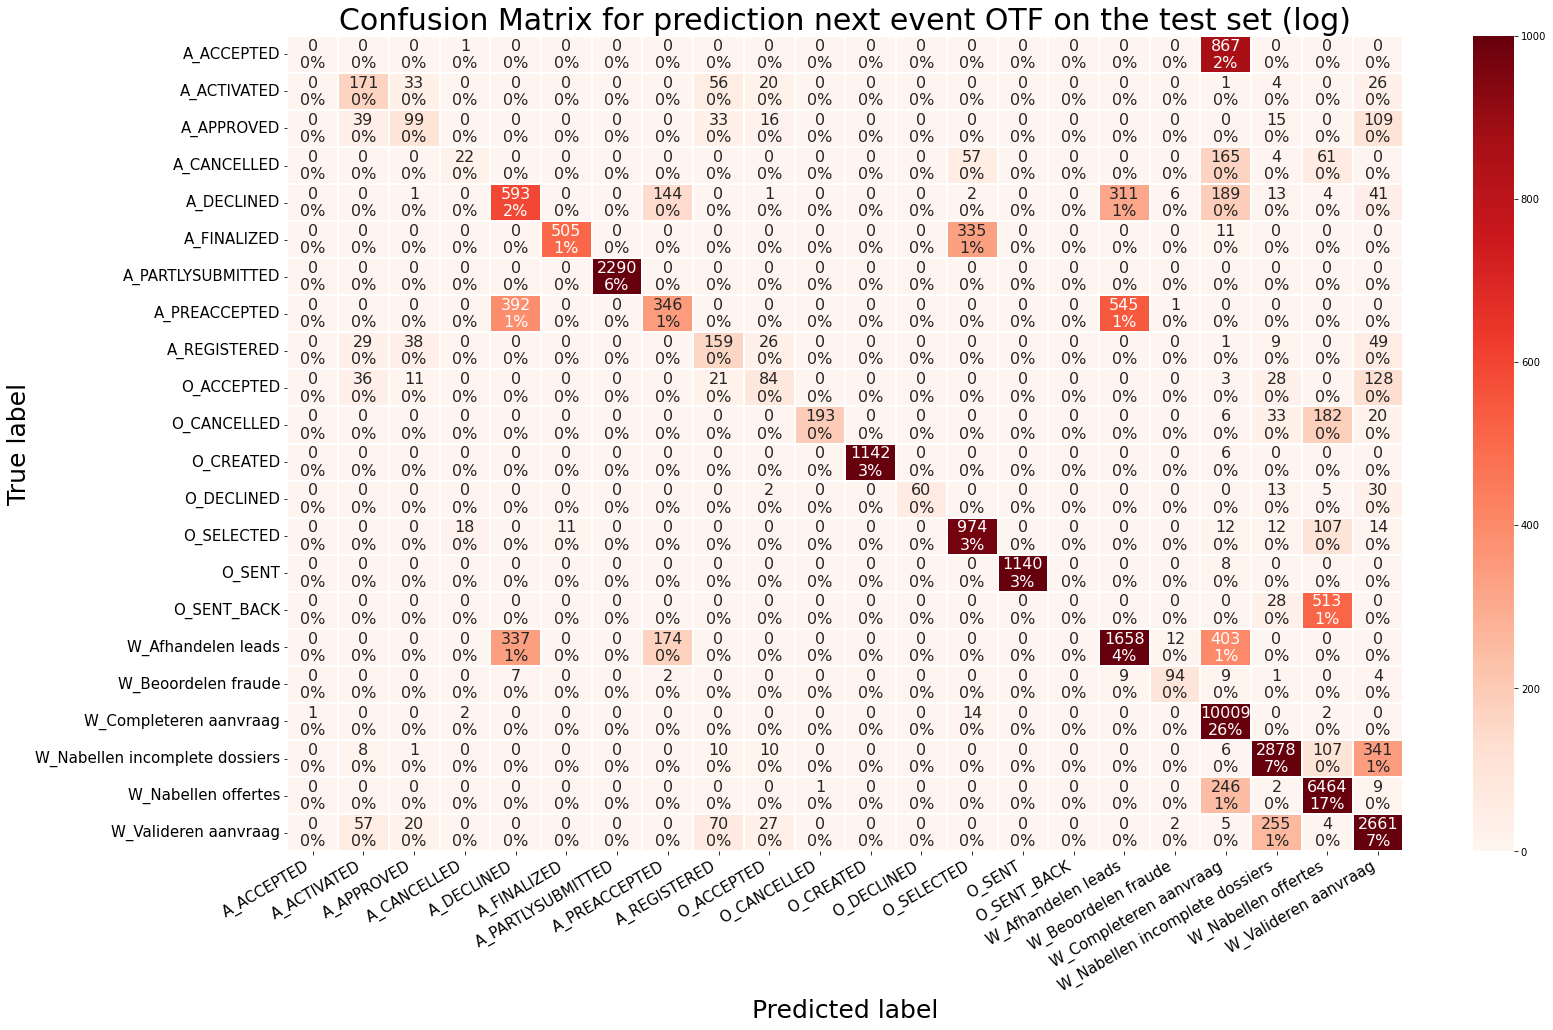

In [19]:
axis_labels = sorted(list(set(y_true)))
matrix = confusion_matrix(y_true, y_pred, labels=axis_labels)
df_matrix = pd.DataFrame(matrix, index=axis_labels, columns=axis_labels)

#get the number of predictions per group
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]

#get the percentage of predictions per group
group_percentages = ["{0:.0%}".format(value) for value in matrix.flatten()/np.sum(matrix)]

#create labels for each cell of the heatmap
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

#reshape into size of the matrix
labels = np.asarray(labels).reshape(matrix.shape)

#set fig size depending on the size of the matrix
plt.figure(figsize=(25,15))

#plot the matrix
sns.heatmap(df_matrix, fmt='', annot=labels, annot_kws={'size':16}, linewidths = 0.3
            , linecolor = 'white', cbar = True, cmap='Reds', vmax=1000)

#set event labels and change color scheme of the matrix
#, xticklabels=events, yticklabels=events, cmap="YlGnBu"

#set x and y label orinetation and size
plt.xticks(rotation=30, horizontalalignment='right', fontsize = 15)
plt.yticks(rotation=0, horizontalalignment='right', fontsize = 15)

#add labels to the plot
plt.xlabel('Predicted label', fontsize=25 )
plt.ylabel('True label', fontsize=25)
plt.title('Confusion Matrix for prediction next event OTF on the test set (log)', fontsize=30)

#plt.savefig('confusion_matrix.png')

plt.show()